In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets
from IPython.display import clear_output

In [2]:
# interactive plots in notebook
# %matplotlib notebook
# open external window with plot
# %matplotlib qt

plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["font.size"] = 18

In [3]:
%load_ext jupyter_spaces

### Summary

We elaborate on the "single cell tip" problem. First we present a possible solution with the `lattice_array_superimpose()` method. The resulting grid is not only asymmetric, but can also no longer be obtained by bisecting a homogeneous coarser gird. It remains to be seen, if this leads to any problems down the line.

Additionally, we discuss restrictions on the parameters for mesh generation that guarantee to produce only double cell tips. In this case we use a much simpler `lattice_array_superimpose_dct()`, which leaves out all of the logic required for valid, general meshes.

**Simple Refactoring**  
This includes obvious optimizations (e.g `sum()` instead of custom loop), reduced copying of arrays for manipulation functions etc.

### Code

#### Plotting Routines

In [4]:
def generate_plot_lattice_1_1D(lattice_array):
    """Generate a Numpy array for mesh plotting.

    Args:
        lattice_array:
            Valid lattice_array. Return value of
            `generate_lattice_array`. 

    Returns:
        Boolean Numpy array representation of the lattice
        with `shape = (2*Nt+1, 2*Ns+1)`. Nt: number of time
        slices, Ns: number of spatial cells, both given in
        units of the overall finest resolution.  
        The return array is meant to be used with the custom
        plotting routines based on matplotlib `imshow`:
        `plot_mesh_1_1D`, `plot_filled_mesh_1_1D`.
    """
    # time steps in finest mesh units
    time_steps = len(lattice_array)
    
    # find spatial resolution in finest mesh units
    # is the same for all time slices => take 0th
    # times two because of border pixels
    fine_mesh = sum(areas[1] * areas[-1]*2 for areas in lattice_array[0])

    # double size, borders take 1px
    # +1 for outermost boundary
    # bool: 0 => cell content, 1 => border
    full_lattice = np.zeros((time_steps*2+1, fine_mesh+1), dtype=np.bool_)
    # needs different type for figuring out time step width of cells
    time_lattice = np.zeros((time_steps*2+1, fine_mesh+1), dtype=np.uint64)

    # set outermost boundary
    full_lattice[-1] = True
    full_lattice[:,-1] = True
    
    # fill lattice_array
    for i in range(time_steps):
        start = 0
        for areas in lattice_array[i]:
            # times two, because of border pixels
            stop = start+areas[-1]*areas[1]*2
            # set correct spatial step with proper stepping through mesh
            full_lattice[2*i, start : stop : areas[1]*2] = areas[1]
            full_lattice[2*i +1, start : stop : areas[1]*2] = areas[1]
            # set time step for all elements
            time_lattice[2*i, start : stop] = areas[0]
            time_lattice[2*i +1, start : stop] = areas[0]
            # set new start for next slice
            start = stop
        
        if start != fine_mesh:
            # TBD: remove the check in favor of external functions
#             raise Exception(
#                 "Invalid lattice_array!\n"
#                 "The number of spatial cells varies between time steps!\n"
#                 f"{i=}, {lattice_array[i]=}, {fine_mesh=}, {start=}"
#             )
            print("Invalid lattice_array!\n"
                "The spatial size of the mesh varies between time steps!\n"
                f"{i=}, {lattice_array[i]=}, {fine_mesh=}, {start=}"
            )
            break

    # set subsequent cells with dt>1 to zero
    # just like for coarser spatial stepping
    for i in range(0, time_steps*2, 2):
        # set smallest time slice borders
        time_lattice[i+1] = 0
        # if there exist coarser time steps
        for t in range(1, np.max(time_lattice[i])):
            time_lattice[i + 2*t][time_lattice[i] > t] = 0
    
    # only keep 0 (empty) where both spatial and time lattice are 0
    # borders (1) overwrite cell content
    np.logical_or(full_lattice, time_lattice, out=full_lattice)
    return full_lattice

In [5]:
def plot_mesh_1_1D(lattice, alpha_bg=False):
    """Plot the mesh corresponding to `lattice`.

    Args:
        lattice:
            Boolean Numpy array with `True` where to draw borders.
            Takes return value of `generate_plot_lattice_1_1D`.
            Shape needs to be (2*Nt+1, 2*Ns+1). Nt: number of time
            slices, Ns: number of spatial cells, both given in
            units of the overall finest resolution.
        alpha_bg:
            If set to `True`, draw black lines on transparent
            background. Else Viridis color theme from Matplotlib
            is used for (0, 1) => (black, white) conversion.
            Default: `False`.

    Returns:
        Tuple of `(fig, ax)`, where `fig` is the generated
        Matplotlib figure and `ax` the axes with the plot.
    """
    fig, ax = plt.subplots()
    ax.set_aspect("equal")
    # remove axis, allow alpha background
    ax.set_xticks([])
    ax.set_yticks([])
    fig.patch.set_visible(False)
    ax.set_frame_on(False)
    
    ax.set_xlabel(r"$x\rightarrow$")
    ax.set_ylabel(r"$t\rightarrow$")
    
    if alpha_bg:
        # convert lattice array to masked array with only values
        # drawn for borders and transparent cells
        grid = np.ma.masked_equal(lattice, False, copy=False)
        ax.imshow(grid, origin="lower", interpolation="none", cmap="gray")
    else:
        ax.imshow(lattice, origin="lower", interpolation="none")
    
    return fig, ax

In [6]:
# FIXME: does not plot field values correctly!!!
def plot_filled_mesh_1_1D(field, lattice):
    """Color a `lattice` with values from `field`.

    Args:
        field: Numpy array with field values to plot. Shape
            needs to be (Nt, Ns). Nt: number of time
            slices, Ns: number of spatial cells, both given in
            units of the overall finest resolution.
        lattice:
            Boolean Numpy array with `True` where to draw borders.
            Takes return value of `generate_plot_lattice_1_1D`.
            Shape needs to be (2*Nt+1, 2*Ns+1). Nt: number of time
            slices, Ns: number of spatial cells, both given in
            units of the overall finest resolution.

    Returns:
        Tuple of `(fig, ax)`, where `fig` is the generated
        Matplotlib figure and `ax` the axes with the plot.
    """
    fig, ax = plt.subplots()
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    fig.patch.set_visible(False)
    ax.set_frame_on(False)
    
    ax.set_xlabel(r"$x\rightarrow$")
    ax.set_ylabel(r"$t\rightarrow$")
    
    # convert lattice array to masked array with only values
    # for borders and transparent cells
    grid = np.ma.masked_equal(lattice, False, copy=False)
    
    ax.imshow(field, origin="lower", extent=(-0.5, grid.shape[1]-1.5, -0.5, grid.shape[0]-1.5))
    ax.imshow(grid, origin="lower", interpolation="none", cmap="gray")
    
    return fig, ax

#### Lattice Array

In [7]:
def generate_lattice_array_1_1D(cells_areas, width_areas, dt_areas, out=None):
    """Generate the lattice_array given by the layout.
    
    Args:
        cells_areas:
            Nested 2D Python list with width of each region
            in units of the stepping for that region, for
            each time slice.
        width_areas:
            Nested 2D Python list with spatial stepping
            for each region, for each time slice.
        dt_areas:
            Nested 2D Python list with temporal stepping
            for each region, for each time slice.
        out:
            lattice_array to store the result.
    
    All arguments must share the same len (for the outermost
    list) and all sublists with the same position in the outer
    list must share the same len as well.
    
    Returns:
        lattice_array that fully characterizes the mesh. 1.
        dim is the number of time steps inherited from the
        arguments. 2. dim is a 2D tuple with the layout (2.
        dim of tuple ) for each region (1.dim of tuple).
    """
    # FIXME: needs try...except for usage of max(), 2 times
    
    # find number of time steps Nt
    # take max so loop below raises error for wrong arguments
    time_steps = max(len(cells_areas), len(width_areas), len(dt_areas))

    if out is None:
        out = np.empty(time_steps, dtype=object)
    
    for i in range(time_steps):
        spatial_regions = max(len(cells_areas[i]), len(width_areas[i]), len(dt_areas[i]))
        out[i] = tuple((dt_areas[i][j], width_areas[i][j], cells_areas[i][j]) for j in range(spatial_regions))
        
    return out

In [8]:
def spatial_lattice_array_mirror(l, out=None):
    """Mirror the given lattice_array `l` in spatial direction.
    
    Args:
        l:
            lattice_array.
            Return value of `generate_lattice_array_1_1D`.
        out:
            lattice_array with same len l.
    
    If `out` is not given, this returns a new lattice_array.
    """
    if out is None:
        out = np.empty(len(l), dtype=object)
    
    # for each time slice
    for t,ll in enumerate(l):
        # reverse the regions
        out[t] = tuple(reversed(ll))
    
    return out

In [9]:
def temporal_lattice_array_mirror(l, out=None):
    """Mirror the given lattice_array in temporal direction.
    
    Args:
        l:
            lattice_array.
            Return value of `generate_lattice_array_1_1D`.
        out:
            lattice_array with same len as l.
        
    If `out` is not given, this returns a new Lattice array.
    """
    if out is None:
        out = np.copy(l)
    else:
        # this works if out is l
        np.copyto(out, l)
    
    return np.flipud(out)

In [10]:
def spatial_lattice_array_extend(left, right, out=None):
    """Append the lattice_array `right` to the spatial right of `left`.
    
    Args:
        left: lattice_array on the spatial left.
        right: lattice_array on the spatial right.
        out:
            lattice_array with same len as l.
    
    All arguments must have the same len.
    
    Returns:
        New lattice_array with len matching the inputs. If
        the touching regions of `left` and `right` have equal
        resolution, they get merged.
    """
    # FIXME: needs try...except for usage of max()
    
    # take max, so that loop below throws error for mismatched shape
    max_len = max(len(left), len(right))
    if out is None:
        out = np.empty(max_len, dtype=object)
    
    for t in range(max_len):
        # check for merge possibility
        # both, temporal and spatial must be equal
        if left[t][-1][0] == right[t][0][0] and left[t][-1][1] == right[t][0][1]:
            middle = ((left[t][-1][0], left[t][-1][1], left[t][-1][-1]+right[t][0][-1]),)
            out[t] = tuple(left[t][:-1] + middle + right[t][1:])
        
        else:
            out[t] = tuple(left[t] + right[t])
    
    return out

##### New Lattice Array Superposition

In [11]:
def lattice_array_superimpose(l, g, out=None):
    # TODO: proper docstring
    # l and g must have same len
    # l and g must have same spatial width
    # => right now not enforced, unexpected behavior
    
    # FIXME: needs try...except for usage of max()
    # take max, so that loop below throws error for mismatched len
    max_t = max(len(l), len(g))
    if out is None:
        out = np.empty(max_t, dtype=object)
    
    # loop through all time slices in l and g
    for t in range(max_t):
        # the current time slices
        lt = l[t]
        gt = g[t]
        
        # manual iteration through lt, gt required
        # create the iterables through the regions
        l_iter = iter(lt)
        g_iter = iter(gt)
        # fetch first elements
        l_r = next(l_iter)
        g_r = next(g_iter)
        
        # output time slice
        o = [(((),),)]
        # offset penaly for mismatched regions
        l_offset, g_offset = 0, 0

        try:
            # fake iteration over lt, gt
            while True:
                # flag for next() fetching
                l_next, g_next = False, False
        
                # set current size
                # leftover from previous round or fresh size with offset penalty
                l_size = l_offset if l_offset>0 else l_r[-1]*l_r[1] + l_offset
                g_size = g_offset if g_offset>0 else g_r[-1]*g_r[1] + g_offset

                # finer resolution prevails
                r_m = (min(l_r[0], g_r[0]), min(l_r[1], g_r[1]))
                
                # regions share size
                if l_size == g_size:
                    num_coa, num_rest = divmod(l_size, r_m[1])
                    
                    # test if region can be filled without remainder
                    if num_rest:
                        if num_coa:
                            # add number of cells that fit
                            o=spatial_lattice_array_extend(
                                o,
                                (((r_m[0], r_m[1], num_coa),),),
                                out=o,
                            )
                            # add 1 finer cell
                            o=spatial_lattice_array_extend(
                                o,
                                (((r_m[0]//2, r_m[1]//2, 1),),),
                                out=o,
                            )
                        else:
                            # no cells fit, use 1 finer cell
                            o=spatial_lattice_array_extend(
                                o,
                                (((r_m[0]//2, r_m[1]//2, 1),),),
                                out=o,
                            )

                        # calculate covered space
                        l_offset = l_size - r_m[1]*num_coa - r_m[1]//2
                        g_offset = g_size - r_m[1]*num_coa - r_m[1]//2
                        # advance iterables
                        if l_offset <= 0:
                            l_r = next(l_iter)
                            l_next = True
                        if g_offset <= 0:
                            g_r = next(g_iter)
                            g_next = True
                        
                        # check next region's resolution
                        if (min(l_r[0], g_r[0]), min(l_r[1], g_r[1])) >= r_m:
                            # next region is same or coarser
                            # undo last fine cell and replace with current resolution
                            
                            if sub:= o[0][-1][-1] - 1:
                                # only if something is left in that region after removal
                                o=spatial_lattice_array_extend(
                                    [o[0][:-1],],
                                    (((o[0][-1][0], o[0][-1][1], sub),),),
                                    out=o,
                                )
                            else:
                                # discard last region
                                o = [o[0][:-1],]
                            
                            # add current resolution cell
                            o=spatial_lattice_array_extend(
                                o,
                                (((r_m[0], r_m[1], 1),),),
                                out=o,
                            )
                            
                            # recalculate covered space
                            l_offset -= r_m[1]//2
                            g_offset -= r_m[1]//2
                            # advance iterables if not done already
                            if l_offset <= 0 and not l_next:
                                l_r = next(l_iter)
                            if g_offset <= 0 and not g_next:
                                g_r = next(g_iter)
                    
                    else:
                        # region can be filled without remainder
                        o=spatial_lattice_array_extend(
                            o,
                            (((r_m[0], r_m[1], num_coa),),),
                            out=o,
                        )
                            
                        # no offset arises
                        l_offset, g_offset = 0, 0
                        l_r = next(l_iter)
                        g_r = next(g_iter)
                        
                elif l_size < g_size:
                    num_coa, num_rest = divmod(l_size, r_m[1])
                    
                    if num_rest:
                        if num_coa:
                            o=spatial_lattice_array_extend(
                                o,
                                (((r_m[0], r_m[1], num_coa),),),
                                out=o,
                            )
                            o=spatial_lattice_array_extend(
                                o,
                                (((r_m[0]//2, r_m[1]//2, 1),),),
                                out=o,
                            )
                        else:
                            o=spatial_lattice_array_extend(
                                o,
                                (((r_m[0]//2, r_m[1]//2, 1),),),
                                out=o,
                            )

                        g_offset = g_size - r_m[1]*num_coa - r_m[1]//2
                        l_offset = l_size - r_m[1]*num_coa - r_m[1]//2
                        if l_offset <= 0:
                            l_r = next(l_iter)
                            l_next = True
                        if g_offset <= 0:
                            g_r = next(g_iter)
                            g_next = True
                        
                        if (min(l_r[0], g_r[0]), min(l_r[1], g_r[1])) >= r_m:
                            
                            if sub:= o[0][-1][-1] - 1:
                                o=spatial_lattice_array_extend(
                                    [o[0][:-1],],
                                    (((o[0][-1][0], o[0][-1][1], sub),),),
                                    out=o,
                                )
                            else:
                                o = [o[0][:-1],]
                            
                            o=spatial_lattice_array_extend(
                                o,
                                (((r_m[0], r_m[1], 1),),),
                                out=o,
                            )
                            
                            l_offset -= r_m[1]//2
                            g_offset -= r_m[1]//2
                            if l_offset <= 0 and not l_next:
                                l_r = next(l_iter)
                            if g_offset <= 0 and not g_next:
                                g_r = next(g_iter)
                    
                    else:
                        o=spatial_lattice_array_extend(
                            o,
                            (((r_m[0], r_m[1], num_coa),),),
                            out=o,
                        )
                    
                        g_offset = g_size-l_size
                        l_offset = 0
                        l_r = next(l_iter)
                        
                # g_size < l_size
                else:
                    num_coa, num_rest = divmod(g_size, r_m[1])
                    
                    if num_rest:
                        if num_coa:
                            o=spatial_lattice_array_extend(
                                o,
                                (((r_m[0], r_m[1], num_coa),),),
                                out=o,
                            )
                            o=spatial_lattice_array_extend(
                                o,
                                (((r_m[0]//2, r_m[1]//2, 1),),),
                                out=o,
                            )
                        else:
                            o=spatial_lattice_array_extend(
                                o,
                                (((r_m[0]//2, r_m[1]//2, 1),),),
                                out=o,
                            )

                        l_offset = l_size - r_m[1]*num_coa - r_m[1]//2
                        g_offset = g_size - r_m[1]*num_coa - r_m[1]//2
                        if l_offset <= 0:
                            l_r = next(l_iter)
                            l_next = True
                        if g_offset <= 0:
                            g_r = next(g_iter)
                            g_next = True
                        
                        if (min(l_r[0], g_r[0]), min(l_r[1], g_r[1])) >= r_m:
                            
                            if sub := o[0][-1][-1] - 1:
                                o=spatial_lattice_array_extend(
                                    [o[0][:-1],],
                                    (((o[0][-1][0], o[0][-1][1], sub),),),
                                    out=o,
                                )
                            else:
                                o = [o[0][:-1],]
                            
                            o=spatial_lattice_array_extend(
                                o,
                                (((r_m[0], r_m[1], 1),),),
                                out=o,
                            )
                            
                            l_offset -= r_m[1]//2
                            g_offset -= r_m[1]//2
                            if l_offset <= 0 and not l_next:
                                l_r = next(l_iter)
                            if g_offset <= 0 and not g_next:
                                g_r = next(g_iter)
                        
                    else:
                        o=spatial_lattice_array_extend(
                            o,
                            (((r_m[0], r_m[1], num_coa),),),
                            out=o,
                        )
                    
                        l_offset = l_size-g_size
                        g_offset = 0
                        g_r = next(g_iter)
                        
        except StopIteration:
            # will catch next([*]_iter) depletion
            
            # TBD: check in code? move to tests?
            # check if iteration ended at same width for both inputs
            if g_offset or l_offset:
                # if other than 0, there is leftover
                raise Exception(
                    f"Error when superimposing\n{lt=}\nand\n{gt=}\n"
                    "The widths of these arrays does not match."
                )
        
        # append current time slice in o to out
        # discard first, empty region
        out[t] = tuple(o[0][1:])
    
    return out

In [12]:
def lattice_array_superimpose_dct(l, g, out=None):
    # TODO: proper docstring, like std superimpose
    # l and g must have same len
    # l and g must have same spatial width
    # => right now not enforced, unexpected behavior
    
    # FIXME: needs try...except for usage of max()
    # take max, so that loop below throws error for mismatched len
    max_t = max(len(l), len(g))
    if out is None:
        out = np.empty(max_t, dtype=object)
    
    # loop through all time slices in l and g
    for t in range(max_t):
        # the current time slices
        lt = l[t]
        gt = g[t]
        
        # manual iteration through lt, gt required
        # create the iterables through the regions
        l_iter = iter(lt)
        g_iter = iter(gt)
        # fetch first elements
        l_r = next(l_iter)
        g_r = next(g_iter)
        
        # output time slice
        o = [(((),),)]
        # offset penaly for mismatched regions
        l_offset, g_offset = 0, 0

        try:
            # fake iteration over lt, gt
            while True:
                # flag for next() fetching
                l_next, g_next = False, False
        
                # set current size
                # leftover from previous round or fresh size with offset penalty
                # FIXME: for dct offsets cannot be negative
                l_size = l_offset if l_offset>0 else l_r[-1]*l_r[1] + l_offset
                g_size = g_offset if g_offset>0 else g_r[-1]*g_r[1] + g_offset

                # finer resolution prevails
                r_m = (min(l_r[0], g_r[0]), min(l_r[1], g_r[1]))
                
                # regions share size
                if l_size == g_size:
                    num_coa, num_rest = divmod(l_size, r_m[1])
                    # add num_coa cells
                    o=spatial_lattice_array_extend(
                        o,
                        (((r_m[0], r_m[1], num_coa),),),
                        out=o,
                    )
                        
                    # no offset, regions have same size
                    l_offset, g_offset = 0, 0
                    # advance iterables
                    l_r = next(l_iter)
                    g_r = next(g_iter)
                        
                elif l_size < g_size:
                    num_coa, num_rest = divmod(l_size, r_m[1])
                    
                    o=spatial_lattice_array_extend(
                        o,
                        (((r_m[0], r_m[1], num_coa),),),
                        out=o,
                    )

                    # calculate covered region
                    g_offset = g_size-l_size
                    l_offset = 0
                    l_r = next(l_iter)
                        
                # g_size < l_size
                else:
                    num_coa, num_rest = divmod(g_size, r_m[1])
                    
                    o=spatial_lattice_array_extend(
                        o,
                        (((r_m[0], r_m[1], num_coa),),),
                        out=o,
                    )

                    l_offset = l_size-g_size
                    g_offset = 0
                    g_r = next(g_iter)
                        
        except StopIteration:
            # will catch next([*]_iter) depletion
            
            # TBD: check in code? move to tests?
            # check if iteration ended at same width for both inputs
            if g_offset or l_offset:
                # if other than 0, there is leftover
                raise Exception(
                    f"Error when superimposing\n{lt=}\nand\n{gt=}\n"
                    "The widths of these arrays do not match."
                )
            
        # append current time slice in o to out
        # discard first, empty region
        out[t] = tuple(o[0][1:])
    
    return out

In [13]:
def propagate_pulse(l, steps, buffer=1, out=None):
    """Propagate l from lower left to upper right.
    
    Args:
        l: spatially symmetric lattice_array to propagate.
        steps: Number of times to repeat `l` in temporal direction.
        buffer:
            Minimum number of coarsest cells to between l and
            boundaries. Default 1.
        out:
            lattice_array with same len as l.
        
    Returns:
        If `out` is not given, this returns a new lattice_array with
        `steps * len(l)` as len and all time slices filling the same
        total spatial width.
    """
    # get resolution of boundaries of l in units
    # of finest mesh, times 2 for new border regions
    # FIXME: what if asymmetric l?
    l_coarsest_t = l[0][0][0] *2
    l_coarsest_x = l[0][0][1] *2
    out_t = steps * len(l)
    
    if out is None:
        out = np.empty(out_t, dtype=object)
    
    # buffer on the right
    rbuffer = buffer - 1 + steps

    # calculate each time slice's regions
    for t in range(out_t):
        # number of buffer cells
        q, r = divmod(t, l_coarsest_t)
        out[t] = (
            (
                (
                    l_coarsest_t,
                    l_coarsest_x,
                    buffer + q
                ),
            )
            + l[r]
            + (
                (
                    l_coarsest_t,
                    l_coarsest_x,
                    rbuffer - q,
                ),
            )
        )

    return out

In [14]:
def propagate_collision(l, steps, buffer=1, out=None):
    """Propagate two pulse segments of `l` in opposite directions."""
    # get resolution of boundaries of l in units
    # of finest mesh, times 2 for new border regions
    # FIXME: what if asymmetric l?
    l_coarsest_t = l[0][0][0] *2
    l_coarsest_x = l[0][0][1] *2
    out_t = steps * len(l)
    
    if out is None:
        out = np.empty(out_t, dtype=object)
    
    # buffer on the right
    rbuffer = buffer - 1 + steps

    # calculate each time slice's regions
    for t in range(0, out_t):
        # number of buffer cells
        q, r = divmod(t, l_coarsest_t)
        # save a segment
        tempA = ((
            (
                (
                    l_coarsest_t,
                    l_coarsest_x,
                    buffer + q
                ),
            )
            + l[r]
            + (
                (
                    l_coarsest_t,
                    l_coarsest_x,
                    rbuffer - q,
                ),
            )
        ),)
        # superimpose with mirrored segment
        out[t] = lattice_array_superimpose(
            tempA,
            spatial_lattice_array_mirror(tempA),
        )[0]

    return out

In [15]:
def homogeneous_fill(time_steps, spatial_width, resolution, out=None):
    """Homogenious lattice_array time_steps x spatial_width and resolution."""
    # out has to have len==time_steps
    # TBD: remove all if's, this should be caught by tests
    # or by generate_lattice_array
    
    num, rest = divmod(spatial_width, resolution[1])
    if rest != 0:
        print("Error:\n"
              f"{resolution[1]=} does not fit into {spatial_width=}.")
        return

    if time_steps%resolution[0] != 0:
        print("Error:\n"
              f"{resolution[0]=} does not fit into {time_steps=}.")
        return
    
    if out is None:
        out = np.empty(time_steps, dtype=object)
    elif len(out) != time_steps:
        print("Error:\n") # TBD:
    
    out.fill(((resolution+(num,)),))
    return out

#### Kayran-Scheme (Fixed Physical Width per Border Region)

In [16]:
def borders_diag_lowL_uppR_segment(coarse_steps, spatial_width):
    """Generate lattice_array segment.
    
    The segment will have `coarse_steps` number of differently
    resolved regions (counting the finest). The borders will be
    diagonally from the lower left to the upper right.
    
    Args:
        coarse_steps: Integer number of different regions.
        spatial_width:
            Even number that sets the width of all coarser than
            finest resolved regions in the spatial direction.
            Minimal value must be $2^{coarse\_steps}$.
            
    Returns:
        1+1D lattice_array as output from `generate_lattice_array_1_1D`
        with len = $2^{coarse\_steps}$ and each element being a tuple
        of 3 tuples of (dt,dx,number). Here number is related to
        `spatial_width`.
    """
    # determine temporal steps to consider
    time_steps = int(2**coarse_steps)
    # prepare return variables
    cells_areas = np.empty(time_steps, dtype=object)
    width_areas = np.empty(time_steps, dtype=object)

    # spatial width per region
    start = tuple(spatial_width // 2**coa for coa in range(coarse_steps-1, 0, -1))
    # TBD:
    # second possibility, more memory usage, but less if and calc
    start1 = tuple(s+1 for s in start)
    sstart = (start, start1)
    
    # width in units of finest mesh for each region
    # include 1 for finest mesh, exclude 2**coarse_steps for coarsest mesh
    width_area = tuple(2**coa for coa in range(coarse_steps-1, -1, -1))
    
    coa1 = coarse_steps-1

    # generate the lattice_array components
    for i in range(2**coa1):
        # the binary encoding of alternating rows (gives straight edge)
#         binIdx = f"{i:{coa1}b}".replace(' ','0')
        # number of cells per area
#         cells_area = [ start[k] if binIdx[k]=='0' else start[k]+1
#                        for k in range(coa1) ] + [2**coarse_steps -2*i -1]
        # TBD:
        # second possibility
        binIdx = tuple(map(int, f"{i:{coa1}b}".replace(' ','0')))
        cells_area = [ sstart[binIdx[k]][k] for k in range(coa1) ] + [2**coarse_steps -2*i -1]

        cells_areas[2*i] = tuple(cells_area)
        width_areas[2*i] = width_area[:]
        cells_areas[2*i + 1] = tuple(cells_area)
        width_areas[2*i + 1] = width_area[:]

    # allow only squares
    dt_areas = width_areas
    
    return generate_lattice_array_1_1D(cells_areas, width_areas, dt_areas)

In [17]:
def pulse_segment(coarse_steps, borders_width, pulse_width, out=None):
    """do docstring"""
    # this will take the indentical body of pulse_lowL_uppR and pulse_collision
    # also of the fixed ones

In [18]:
def pulse_lowL_uppR(coarse_steps, borders_width, pulse_width, temp_scale, buffer=1):
    """Generate a pulse travelling from lower left to upper right.
    
    Args:
        coarse_steps: Number of times to coarsen the pulse.
        borders_width:
            Spatial width of the pulse-border regions measured
            in resolution of the finest mesh (the pulse).
        pulse_width: Spatial width of the pulse in its units.
        temp_scale: Number of times to repeat the pulse segment.
        buffer:
            Default `1`. Number of coarsest cells to insert in order
            to prevent the pulse form touching the box boundaries.
    """
    m = borders_diag_lowL_uppR_segment(coarse_steps, borders_width)
    # create right_segment from unmodified m
    right_segment = temporal_lattice_array_mirror(m)
    right_segment = spatial_lattice_array_mirror(right_segment, out=right_segment)
    
    # only if width of finest region is lager than minimal value
    # add difference only to right_segment from the left
    if 0 < (add_fine_width := pulse_width - 2 ** coarse_steps):
        fine = np.empty(len(right_segment), dtype=object)
        fine.fill(((1, 1, add_fine_width),))
        right_segment = spatial_lattice_array_extend(fine, right_segment, out=right_segment)
    
    return propagate_pulse(
        spatial_lattice_array_extend(
            m,
            right_segment,
            out=m,
        ),
        temp_scale,
        buffer,
    )

In [19]:
def pulse_collision(coarse_steps, borders_width, pulse_width, temp_scale, buffer=1):
    """Generate collision of 2 pulses."""
    
    m = borders_diag_lowL_uppR_segment(coarse_steps, borders_width)
    # create right_segment from unmodified m
    right_segment = temporal_lattice_array_mirror(m)
    right_segment = spatial_lattice_array_mirror(right_segment, out=right_segment)
    
    # only if width of finest region is lager than minimal value
    # add difference only to right_segment from the left
    if 0 < (add_fine_width := pulse_width - 2 ** coarse_steps):
        fine = np.empty(len(right_segment), dtype=object)
        fine.fill(((1, 1, add_fine_width),))
        right_segment = spatial_lattice_array_extend(fine, right_segment, out=right_segment)
        
    # generate collision
    return propagate_collision(
        spatial_lattice_array_extend(
            m,
            right_segment,
            out=m,
        ),
        temp_scale,
        buffer,
    )

#### Ipp-Scheme (Fixed Number of Cells per Border Region)

In [20]:
def fixed_borders_diag_lowL_uppR_segment(coarse_steps, spatial_width):
    """Generate lattice_array segment.
    
    The segment will have `coarse_steps` number of differently
    resolved regions (counting the finest). The borders will be
    diagonally from the lower left to the upper right.
    
    Args:
        coarse_steps: Integer number of different regions.
        spatial_width:
            Even number that sets the width of all coarser than
            finest resolved regions in the spatial direction.
            Minimal value must be $2^{coarse\_steps}$.
            
    Returns:
        1+1D lattice_array as output from `generate_lattice_array_1_1D`
        with len = $2^{coarse\_steps}$ and each element being a tuple
        of 3 tuples of (dt,dx,number). Here number is related to
        `spatial_width`.
    """
    # determine temporal steps to consider
    time_steps = int(2**coarse_steps)
    # prepare return variables
    cells_areas = np.empty(time_steps, dtype=object)
    width_areas = np.empty(time_steps, dtype=object)

    # spatial width per area
#     start = tuple(spatial_width // 2**coa for coa in range(coarse_steps-1, 0, -1))
    start = spatial_width
    # TBD:
    # second possibility, more memory usage, but less if and calc
#     start1 = tuple(s+1 for s in start)
    start1 = start + 1
    sstart = (start, start1)
    
    # width in units of finest mesh for each area
    # include 1 for finest mesh, exclude 2**coarse_steps for coarsest mesh
    width_area = tuple(2**coa for coa in range(coarse_steps-1, -1, -1))
    
    coa1 = coarse_steps-1

    # generate the lattice_array components
    for i in range(2**coa1):
        # the binary encoding of alternating rows (gives straight edge)
#         binIdx = f"{i:{coa1}b}".replace(' ','0')
        # number of cells per area
#         cells_area = [ start[k] if binIdx[k]=='0' else start[k]+1
#                        for k in range(coa1) ] + [2**coarse_steps -2*i -1]
        # TBD:
        # second possibility
        binIdx = tuple(map(int, f"{i:{coa1}b}".replace(' ','0')))
#         cells_area = [ sstart[binIdx[k]][k] for k in range(coa1) ] + [2**coarse_steps -2*i -1]
        cells_area = [ sstart[binIdx[k]] for k in range(coa1) ] + [2**coarse_steps -2*i -1]

        cells_areas[2*i] = tuple(cells_area)
        width_areas[2*i] = width_area[:]
        cells_areas[2*i + 1] = tuple(cells_area)
        width_areas[2*i + 1] = width_area[:]

    # allow only squares
    dt_areas = width_areas
    
    return generate_lattice_array_1_1D(cells_areas, width_areas, dt_areas)

In [21]:
def fixed_borders_pulse_lowL_uppR(coarse_steps, borders_width, pulse_width, temp_scale, buffer=1):
    """Generate a pulse travelling from lower left to upper right.
    
    Args:
        coarse_steps: Number of times to coarsen the pulse.
        borders_width:
            Spatial width of the pulse-border regions measured
            in resolution of the finest mesh (the pulse).
        pulse_width: Spatial width of the pulse in its units.
        temp_scale: Number of times to repeat the pulse segment.
        buffer:
            Default `1`. Number of coarsest cells to insert in order
            to prevent the pulse form touching the box boundaries.
    """
    m = fixed_borders_diag_lowL_uppR_segment(coarse_steps, borders_width)
    # create right_segment from unmodified m
    right_segment = temporal_lattice_array_mirror(m)
    right_segment = spatial_lattice_array_mirror(right_segment, out=right_segment)
    
    # only if width of finest region is lager than minimal value
    # add difference only to right_segment from the left
    if 0 < (add_fine_width := pulse_width - 2 ** coarse_steps):
        fine = np.empty(len(right_segment), dtype=object)
        fine.fill(((1, 1, add_fine_width),))
        right_segment = spatial_lattice_array_extend(fine, right_segment, out=right_segment)
        
    return propagate_pulse(
        spatial_lattice_array_extend(
            m,
            right_segment,
            out=m,
        ),
        temp_scale,
        buffer,
    )

In [22]:
def fixed_borders_pulse_collision(coarse_steps, borders_width, pulse_width, temp_scale, buffer=1):
    """Generate collision of 2 pulses."""

    m = fixed_borders_diag_lowL_uppR_segment(coarse_steps, borders_width)
    # create right_segment from unmodified m
    right_segment = temporal_lattice_array_mirror(m)
    right_segment = spatial_lattice_array_mirror(right_segment, out=right_segment)
    
    # only if width of finest region is lager than minimal value
    # add difference only to right_segment from the left
    if 0 < (add_fine_width := pulse_width - 2 ** coarse_steps):
        fine = np.empty(len(right_segment), dtype=object)
        fine.fill(((1, 1, add_fine_width),))
        right_segment = spatial_lattice_array_extend(fine, right_segment, out=right_segment)
        
    # generate collision
    return propagate_collision(
        spatial_lattice_array_extend(
            m,
            right_segment,
            out=m,
        ),
        temp_scale,
        buffer,
    )

### Solving the "Single Cell Tip" Problem

We had already introduced the basic idea in part7. By using integer division `//` for dividing the available space by the width of the current resolution we make sure the available space is not overstepped. The main problem is how to deal with the rest of the space, that cannot be filled with the current sized cells. Simply using one step finer cells is not the correct way in general. E.g. if the next region would continue with the current resolution, filling with one step finer cells will introduce an awkward stripe of finer resolution which is not intended or needed (See img below). Instead, in this case overfilling the region with the current resolution and carrying a spatial size penalty over to the next region will fix this problem. So in the end, only if the next region will be composed of finer cells it is reasonable to also fill the rest of the current region with those finer cells.

In essence, this is what `lattice_array_superimpose()`[&#182;](#New-Lattice-Array-Superposition) does. It only places as many cells of coarser resolution into the current region, as there is space for them and fills the rest with one cell of one step finer resolution. If the next region would have the same resolution as the current region, the last added finer cell is removed and replaced with the a cell of coarser resolution. The amount of space that is now additionally taken is passed on to the next region as a negative offset.

**Awkward Stripes**
![](imgs/singleCellTip_problem_awkward_stripes.png)

In [23]:
%%space collision

# sliders
coarse_steps_slider = widgets.IntSlider(3, 1, 10)
borders_width_slider = widgets.IntSlider(8, 8, 64, 2)
steps_slider = widgets.IntSlider(6,1,100)
buffer_slider = widgets.IntSlider(1, 1, 100)
pulse_width_slider = widgets.IntSlider(12, 8, 64)
# checkboxes
alpha_bg = widgets.Checkbox(description="Black Mesh on Alpha Background", indent=False)
# radio buttons
scheme = widgets.RadioButtons(
    options=['Fixed Number (Ipp-Scheme)', 'Fixed Width (Kayran-Scheme)'],
    value='Fixed Width (Kayran-Scheme)',
    layout={'width': 'max-content'},
)

# plot mesh button
b = widgets.Button(description="Plot Lattice", tooltip="Click me")

# link slider values
def set_borders_width_min(*args, **kwargs):
    """Set scale slider min if coarse steps change."""
    borders_width_slider.min = 2**coarse_steps_slider.value
    borders_width_slider.max = 2**coarse_steps_slider.value*8

coarse_steps_slider.observe(set_borders_width_min)

def set_pulse_width_min(*args, **kwargs):
    """Set pulse_width slider min if coarse steps change."""
    pulse_width_slider.min = 2**coarse_steps_slider.value
    pulse_width_slider.max = 2**coarse_steps_slider.value*8

coarse_steps_slider.observe(set_pulse_width_min)

# labels
borders_width_label = widgets.Label("Spatial Width of Border Regions [Finest Resolution Units]")
coarse_steps_label = widgets.Label("Number of Coarse Borders")
steps_label = widgets.Label("Pulse Segment Repetitions")
buffer_label = widgets.Label("Buffer Region Spatial Width [Coarsest Resolution Units]")
pulse_width_label = widgets.Label("Pulse Kernel Spatial Width [Finest Resolution Units]")
scheme_label = widgets.Label("Scheme for Boundary Regions:")

# change border region label on scheme change
def change_borders_label(*args, **kwargs):
    if scheme.value == "Fixed Number (Ipp-Scheme)":
        borders_width_label.value = "Spatial Width of Border Regions [Number of Cells]"
    elif scheme.value == "Fixed Width (Kayran-Scheme)":
        borders_width_label.value = "Spatial Width of Border Regions [Finest Resolution Units]"

scheme.observe(change_borders_label)
        
# control output
plot_out = widgets.Output()

def click_button(b):
    plot_out.clear_output()
    
    if scheme.value == "Fixed Number (Ipp-Scheme)":
        selected_pulse_lowL_uppR = fixed_borders_pulse_lowL_uppR
        selected_pulse_collision = fixed_borders_pulse_collision
    elif scheme.value == "Fixed Width (Kayran-Scheme)":
        selected_pulse_lowL_uppR = pulse_lowL_uppR
        selected_pulse_collision = pulse_collision
    
    check_lattice = selected_pulse_lowL_uppR(
            coarse_steps_slider.value,
            borders_width_slider.value,
            pulse_width_slider.value,
            steps_slider.value,
            buffer_slider.value,
        )

    plot_lattice = generate_plot_lattice_1_1D(
        selected_pulse_collision(
            coarse_steps_slider.value,
            borders_width_slider.value,
            pulse_width_slider.value,
            steps_slider.value,
            buffer_slider.value,
        )
    )
        
    with plot_out:
        plot_mesh_1_1D(generate_plot_lattice_1_1D(check_lattice), alpha_bg.value)
        plot_mesh_1_1D(generate_plot_lattice_1_1D(spatial_lattice_array_mirror(check_lattice)), alpha_bg.value)
        
        plot_mesh_1_1D(plot_lattice, alpha_bg.value)
        plt.show()

b.on_click(click_button)

# display everything
display(
    widgets.VBox([
            widgets.HBox([
                widgets.VBox(
                    [coarse_steps_label, borders_width_label, steps_label, buffer_label, pulse_width_label],
                ),
                widgets.VBox(
                    [coarse_steps_slider, borders_width_slider, steps_slider, buffer_slider, pulse_width_slider],
                ),
                widgets.VBox(
                    [alpha_bg, scheme_label, scheme]
                )
            ]),
            b,
    ])
)
display(plot_out)

Output()

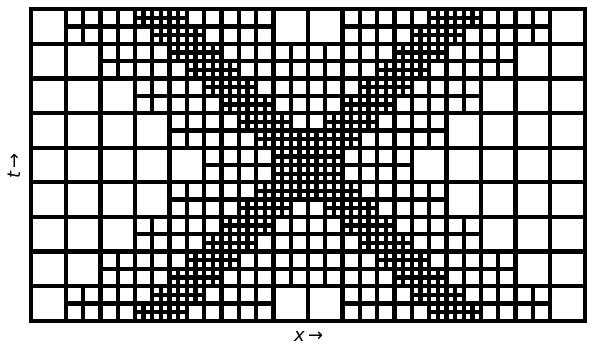

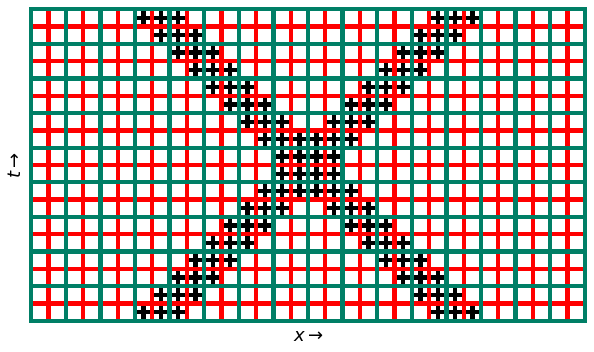

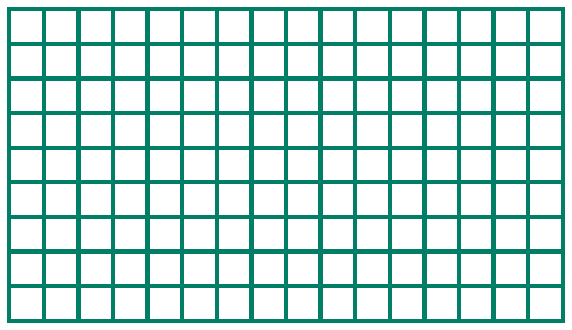

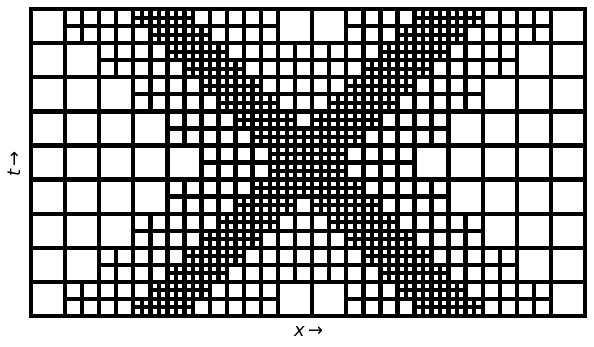

In [24]:
%%space lattice_overlays

# second set for double tip
# Number of Coarse Borders 2 2
# Spatial Width of Border Regions [Finest Resolution Units] 8 8
# Pulse Segment Repetitions 9 9
# Buffer Region Spatial Width [Coarsest Resolution Units] 1 1
# Pulse Kernel Spatial Width [Finest Resolution Units] 7 6

# configure colors
colors = ['spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia']

# nice double cell tip
lattice = pulse_collision(
        2,
        8,
        6,
        9,
        1,
    )

plot_lattice = generate_plot_lattice_1_1D(lattice)

_, _ = plot_mesh_1_1D(plot_lattice, True)
fig, ax = plot_mesh_1_1D(plot_lattice, True)

# plot homogenious meshes for all resolutions in between
spatial_width = sum(a[-1]*a[1] for a in lattice[0])
temporal_width = len(lattice)

newfig, newax = plt.subplots()
newfig.patch.set_visible(False)
newax.set_frame_on(False)
_ = newax.set_xticks([])
_ = newax.set_yticks([])
for res in range(2,lattice[0][0][1]+1,2):
    hom = homogeneous_fill(temporal_width, spatial_width, (res, res))
    hom = generate_plot_lattice_1_1D(hom)
    grid = np.ma.masked_equal(hom, False, copy=False)
    _ = ax.imshow(grid, origin="lower", interpolation="none", cmap=colors[lattice[0][0][1]//res])

_ = newax.imshow(grid, origin="lower", interpolation="none", cmap=colors[lattice[0][0][1]//res])

# now the problematic one
lattice = pulse_collision(
        2,
        8,
        7,
        9,
        1,
    )

plot_lattice = generate_plot_lattice_1_1D(lattice)

_, _ = plot_mesh_1_1D(plot_lattice, True)
    
plt.show()

**Bisection of Coarser Mesh Not Possible**
![](imgs/singleCellTip_problem2.png)

#### Asymmetry of Single Cell Tips

The asymmetric configuration of single cell tip collision meshes is obvious. Not only are the coarser cells under the tip placed spatially asymmetric in the lattice, but also the parts of the pulses on the right half are one fine cell broader. This asymmetry arises from the simple fact, that for single cell tips it is no longer possible to obtain the final mesh by bisecting a homogeneous coarse mesh. The pictures above illustrate how selectively bisecting each cell 2 times and repeating this procedure yields a symmetric collision mesh. However, in the asymmetric case it is no longer possible to find a homogeneous, course mesh that matches all borders. This is the result of the spatial width of the mesh not being modulo the width of the course cells any more. Removing the extra thickness of the pulses on the right half would only fix this problem to the right of the pulses, not for the region under the tip. And by doing so, the spatial width of the whole lattice would be changed.

Another side effect of the single cell tips is, that we now have more higher resolution cells because we fill remaining space with finer cells.

#### Forcing Double Cell Tips

In [25]:
%%space double_cell_tips

# sliders
coarse_steps_slider = widgets.IntSlider(3, 1, 10)
borders_width_slider = widgets.IntSlider(8, 8, 64, 2)
steps_slider = widgets.IntSlider(8,1,100)
buffer_slider = widgets.IntSlider(1, 1, 100)
pulse_width_slider = widgets.IntSlider(10, 8, 64)
# checkboxes
alpha_bg = widgets.Checkbox(description="Black Mesh on Alpha Background", indent=False)
cell_tip = widgets.Checkbox(description="Limit to Double Cell Tips", indent = False)
isolated_pulses = widgets.Checkbox(description="Plot Isolated Pulses Before Superposition", indent=False, value=True)
# radio buttons
scheme = widgets.RadioButtons(
    options=['Fixed Number (Ipp-Scheme)', 'Fixed Width (Kayran-Scheme)'],
    value='Fixed Width (Kayran-Scheme)',
    layout={'width': 'max-content'},
)

# plot mesh button
b = widgets.Button(description="Plot Lattice", tooltip="Click me")

# labels
borders_width_label = widgets.Label("Spatial Width of Border Regions [Finest Resolution Units]")
coarse_steps_label = widgets.Label("Number of Coarse Borders")
steps_label = widgets.Label("Pulse Segment Repetitions")
buffer_label = widgets.Label("Buffer Region Spatial Width [Coarsest Resolution Units]")
pulse_width_label = widgets.Label("Pulse Kernel Spatial Width [Finest Resolution Units]")
scheme_label = widgets.Label("Scheme for Boundary Regions:")

# update functions for slider / select events
def set_borders_width_min(*args, **kwargs):
    """Set scale slider min if coarse steps change."""
    borders_width_slider.max = 2**coarse_steps_slider.value*8
    if scheme.value == "Fixed Number (Ipp-Scheme)":
        borders_width_slider.min = 2
    elif scheme.value == "Fixed Width (Kayran-Scheme)":
        borders_width_slider.min = 2**coarse_steps_slider.value

def set_pulse_width_min(*args, **kwargs):
    """Set pulse_width slider min if coarse steps change."""
    coa_sum = sum(2**coa for coa in range(1, coarse_steps_slider.value))
    steps_power = 2**coarse_steps_slider.value
    if cell_tip.value:
        pulse_width_slider.step = steps_power
        # limit to double cell tips
        if scheme.value == "Fixed Number (Ipp-Scheme)":
            pulse_width_slider.min = (steps_power -
                                         ((1+borders_width_slider.value) * coa_sum
                                         ) % steps_power
                                      ) *2 + coa_sum
        
        elif scheme.value == "Fixed Width (Kayran-Scheme)":
            pulse_width_slider.min = (steps_power - 
                                         (sum(2**coa * (borders_width_slider.value//2**coa)
                                             for coa in range(1, coarse_steps_slider.value)
                                         ) + coa_sum
                                         ) % steps_power
                                      ) *2 + coa_sum
    else:
        pulse_width_slider.step = 1
        pulse_width_slider.min = steps_power
    
    pulse_width_slider.value = pulse_width_slider.min
    pulse_width_slider.max = steps_power*8
        
# change border region label on scheme change
def change_borders_label(*args, **kwargs):
    if scheme.value == "Fixed Number (Ipp-Scheme)":
        borders_width_label.value = "Spatial Width of Border Regions [Number of Cells]"
    elif scheme.value == "Fixed Width (Kayran-Scheme)":
        borders_width_label.value = "Spatial Width of Border Regions [Finest Resolution Units]"

# register all callbacks        
coarse_steps_slider.observe(set_borders_width_min)
coarse_steps_slider.observe(set_pulse_width_min)
borders_width_slider.observe(set_pulse_width_min)
cell_tip.observe(set_pulse_width_min)
scheme.observe(change_borders_label)
scheme.observe(set_borders_width_min)
scheme.observe(set_pulse_width_min)

# control output
plot_out = widgets.Output()

def click_button(b):
    plot_out.clear_output()
    
    if scheme.value == "Fixed Number (Ipp-Scheme)":
        selected_pulse_lowL_uppR = fixed_borders_pulse_lowL_uppR
        selected_pulse_collision = fixed_borders_pulse_collision
    elif scheme.value == "Fixed Width (Kayran-Scheme)":
        selected_pulse_lowL_uppR = pulse_lowL_uppR
        selected_pulse_collision = pulse_collision
    
    check_lattice = selected_pulse_lowL_uppR(
            coarse_steps_slider.value,
            borders_width_slider.value,
            pulse_width_slider.value,
            steps_slider.value,
            buffer_slider.value,
        )
    
    plot_lattice = generate_plot_lattice_1_1D(
        selected_pulse_collision(
            coarse_steps_slider.value,
            borders_width_slider.value,
            pulse_width_slider.value,
            steps_slider.value,
            buffer_slider.value,
        )
    )
        
    with plot_out:
        if isolated_pulses.value:
            plot_mesh_1_1D(generate_plot_lattice_1_1D(check_lattice), alpha_bg.value)
            plot_mesh_1_1D(generate_plot_lattice_1_1D(spatial_lattice_array_mirror(check_lattice)), alpha_bg.value)
        
        plot_mesh_1_1D(plot_lattice, alpha_bg.value)
        plt.show()

b.on_click(click_button)

# display everything
display(
    widgets.VBox([
            widgets.HBox([
                widgets.VBox(
                    [coarse_steps_label, borders_width_label, steps_label, buffer_label, pulse_width_label],
                ),
                widgets.VBox(
                    [coarse_steps_slider, borders_width_slider, steps_slider, buffer_slider, pulse_width_slider],
                ),
                widgets.VBox(
                    [alpha_bg, cell_tip, isolated_pulses, scheme_label, scheme]
                )
            ]),
            b,
    ])
)
display(plot_out)

Output()

As mentioned in the previous section, double cell tips in the symmetric setting are only possible if the spatial lattice size is modulo the coarsest cell. This can be enforced in many ways. We choose the simplest, which is to limit the size of the pulse width (`set_pulse_width_min`). Because the pulse consist of the finest cells of the mesh, it is possible to scale the spatial dimension in the smallest possible steps.

In theory we can calculate the minimally required width of the pulse ($pulse\_width$) by taking the remainder of the division of the width of the entire border region ($\sum borders$, sum of all individual $borders\_width$) by the size of the largest cell on any given lattice $2^{coarse\_steps}$. Then we choose ($pulse\_width$) such that the remainder plus $pulse\_width$ is again modulo $2^{coarse\_steps}$:
$$
\begin{align}
remainder &= (\sum borders)\, \%\, 2^{coarse\_steps} \\
pulse\_width &= 2^{coarse\_steps} - remainder \quad [\text{modulo } 2^{coarse\_steps}]
\end{align}
$$

If this still works out in practice depends on the sorting of the differently resolved cells and the positions of their borders. $\sum borders$ could be an integer multiple of $2^{coarse\_steps}$, but laid out in a way where overlaying $2^{coarse\_steps}$ sized cells would result in "hanging" borders which are not covered by finer cells. This is shown by this example:
![](imgs/bad_sorting_borders_region.png)

However, in our case we do not encounter such a problem. If we first look at the left borders region of a pulse, the sorting is with descending cell size. If we overlay that part of the pulse with the largest cells, the last cell (furthest to the right) will either be perfectly or partly filled, with all previous borders matching up. The same is true when we look at the right borders region with ascending cell size. The described problem only arises, when the strict descending (or ascending) order is broken, namely when combining the left and right borders regions to a pulse. But if me make sure, that the width of the two parts is modulo $2^{coarse\_steps}$ before combining them, the problem is circumvented.

We therefore end up with the following equations that define the $pulse\_width$. We have to derive two different results for the different schemes:
![](imgs/double_cell_tip_calculation.png)

**Kayran-Scheme:**  
First we calculate the width of the borders region for the first and last time slices of a half pulse segment, marked blue (flipped for right side!) and red respectively. The last time slice has one additional cell for each resolution.
$$
\begin{align}
\sum {borders}_{blue} &= \sum_{coa=1}^{coarse\_steps-1} (borders\_width\, //\, 2^{coa})\, 2^{coa}, \\
\sum {borders}_{red} &= \sum_{coa=1}^{coarse\_steps-1} (borders\_width\, //\, 2^{coa} + 1)\, 2^{coa}.
\end{align}
$$
Clearly the difference (marked green) is:
$$
\Delta = \sum_{coa=1}^{coarse\_steps-1} 2^{coa}.
$$
With ${borders}_{red}$ we can calculate the amount of finest cells needed to fill the last time slice and make it modulo $2^{coarse\_steps}$ using the approach described above. This will be the area marked in yellow. As these cells define the units of the lattice, their amount (i.e. "how many") is equivalent to the width of that region.
$$
\sum {borders}_{yellow} = 2^{coarse\_steps} - \frac{\sum_{coa=1}^{coarse\_steps-1} (\frac{borders\_width}{//\, 2^{coa}} + 1)\, 2^{coa}}{\%\, 2^{coarse\_steps}}.
$$
We suggest the notation with % and // in front of the denominator in order to show what kind of division is taking place.

We must not forget, that the yellow region is required for the left and right half of the pulse segment. For the final result $\sum {borders}_{yellow}$ therefore needs to be doubled. Finally, we also need to add $\Delta$ and arrive at
$$
finest\_width = 2 \left[ 2^{coarse\_steps} - \frac{\sum_{coa=1}^{coarse\_steps-1} (\frac{borders\_width}{//\, 2^{coa}} + 1)\, 2^{coa}}{\%\, 2^{coarse\_steps}} \right] + \sum_{coa=1}^{coarse\_steps-1} 2^{coa}.
$$
This is the sum of the green and yellow regions in the picture. Note though, that this result does not represent the most narrow pulse possible. If $\sum {borders}_{yellow} = 2^{coarse\_steps}$ the pulse width will be $2*2^{coarse\_steps} + \sum_{coa=1}^{coarse\_steps-1} 2^{coa}$. This result is one $2^{coarse\_steps}$ broader than the smallest possible pulse for the given configuration. As we are typically interested in broad finest resolution regions, this will not bother us.

The entire pulse segment is guaranteed to be modulo $2^{coarse\_steps}$ by design. To ensure that this property is upheld, we set the step size for the width of the finest region to $2^{coarse\_steps}$.

**Ipp-Scheme:**  
The same procedure applies here. Only the calculation for the width of the red and blue regions has to be slightly modified.
$$
finest\_width = 2 \left[ 2^{coarse\_steps} - \frac{(borders\_width+1) \sum_{coa=1}^{coarse\_steps-1} 2^{coa}}{\%\, 2^{coarse\_steps}} \right] + \sum_{coa=1}^{coarse\_steps-1} 2^{coa}
$$

### Double Cell Tips for the Coarsest Region

The above procedure forces double cell tips up to (not including) the coarsest region. This is visible from the output of the last plots and can be explained by the fact, that we derived the restrictions from a uniform mesh of the coarsest resolution (picture with green grid in text above). If we now want double cell tips including the coarsest resolution region, we could expand on the restrictions for the finest region or take a different approach. From the last results we know, that our mesh can be obtained by bisecting a uniform mesh of the coarsest resolution. If we always want double cell tips, we could just adjust the size of this base mesh to be even in the spacial direction. This would mean, that our mesh now results from the bisection of a uniform mesh of one step coarser than the coarsest region we have. But we cannot enforce this restriction on the entire mesh, as the temporal direction does not have to be evenly divisable into the coarsest resolution, as shown by this figure:

![](imgs/true_double_cell_tips.png)

This red mesh only aligns with the entire lattice, if the pulse segment discussed in the previous section fits an even number of coarsest cells, which we clearly did not enforce.

So the simplest way to adjust the coarsest base mesh is to just limit the pulse segment repetitions so that a single moving pulse will always span a spacial width of even number in the coarsest resolution. As each repetition adds a "column" of the coarsest cell's width, we aim for $N+1$ repetitions if $N$ coarsest cells fit into the width of a pulse segment.

![](imgs/dct_repetition_count.png)

Implementing this logic leads to the final configuration:

In [26]:
%%space strict_double_cell_tips

# sliders
coarse_steps_slider = widgets.IntSlider(3, 1, 10)
borders_width_slider = widgets.IntSlider(8, 8, 64, 2)
steps_slider = widgets.IntSlider(9,1,100)
buffer_slider = widgets.IntSlider(1, 1, 100)
pulse_width_slider = widgets.IntSlider(10, 8, 64)
# checkboxes
alpha_bg = widgets.Checkbox(description="Black Mesh on Alpha Background", indent=False)
cell_tip = widgets.Checkbox(description="Limit to Double Cell Tips", indent = False)
isolated_pulses = widgets.Checkbox(description="Plot Isolated Pulses Before Superposition", indent=False, value=True)
# radio buttons
scheme = widgets.RadioButtons(
    options=['Fixed Number (Ipp-Scheme)', 'Fixed Width (Kayran-Scheme)'],
    value='Fixed Width (Kayran-Scheme)',
    layout={'width': 'max-content'},
)

# plot mesh button
b = widgets.Button(description="Plot Lattice", tooltip="Click me")

# labels
borders_width_label = widgets.Label("Spatial Width of Border Regions [Finest Resolution Units]")
coarse_steps_label = widgets.Label("Number of Coarse Borders")
steps_label = widgets.Label("Pulse Segment Repetitions")
buffer_label = widgets.Label("Buffer Region Spatial Width [Coarsest Resolution Units]")
pulse_width_label = widgets.Label("Pulse Kernel Spatial Width [Finest Resolution Units]")
scheme_label = widgets.Label("Scheme for Boundary Regions:")

# update functions for slider / select events
def set_borders_width_min(*args, **kwargs):
    """Set scale slider min if coarse steps change."""
    borders_width_slider.max = 2**coarse_steps_slider.value*8
    if scheme.value == "Fixed Number (Ipp-Scheme)":
        borders_width_slider.min = 2
    elif scheme.value == "Fixed Width (Kayran-Scheme)":
        borders_width_slider.min = 2**coarse_steps_slider.value

def set_pulse_width_min(*args, **kwargs):
    """Set pulse_width slider min if coarse steps change."""
    coa_sum = sum(2**coa for coa in range(1, coarse_steps_slider.value))
    steps_power = 2**coarse_steps_slider.value
    if cell_tip.value:
        pulse_width_slider.step = steps_power
        # limit to double cell tips
        if scheme.value == "Fixed Number (Ipp-Scheme)":
            pulse_width_slider.min = (steps_power -
                                         ((1+borders_width_slider.value) * coa_sum
                                         ) % steps_power
                                      ) *2 + coa_sum
        
        elif scheme.value == "Fixed Width (Kayran-Scheme)":
            pulse_width_slider.min = (steps_power - 
                                         (sum(2**coa * (borders_width_slider.value//2**coa)
                                             for coa in range(1, coarse_steps_slider.value)
                                         ) + coa_sum
                                         ) % steps_power
                                      ) *2 + coa_sum
    else:
        pulse_width_slider.step = 1
        pulse_width_slider.min = steps_power
    
    pulse_width_slider.value = pulse_width_slider.min
    pulse_width_slider.max = steps_power*8
        
def set_repetitions_min(*args, **kwargs):
    """Set repetitions slider min to enforce double cell tips."""
    coa_sum = sum(2**coa for coa in range(1, coarse_steps_slider.value))
    steps_power = 2**coarse_steps_slider.value
    if cell_tip.value:
        steps_slider.step = 2
        if scheme.value == "Fixed Number (Ipp-Scheme)":
            steps_slider.min = (2 * borders_width_slider.value * coa_sum
                                  + coa_sum
                                  + pulse_width_slider.value
                               ) / steps_power + 3
        elif scheme.value == "Fixed Width (Kayran-Scheme)":
            steps_slider.min = (2* sum(
                                    2**coa * (borders_width_slider.value//2**coa)
                                    for coa in range(1, coarse_steps_slider.value)
                                  ) + coa_sum
                                  + pulse_width_slider.value
                               ) / steps_power + 3
            
    else:
        steps_slider.min = 1
        steps_slider.step = 1
        
# change border region label on scheme change
def change_borders_label(*args, **kwargs):
    if scheme.value == "Fixed Number (Ipp-Scheme)":
        borders_width_label.value = "Spatial Width of Border Regions [Number of Cells]"
    elif scheme.value == "Fixed Width (Kayran-Scheme)":
        borders_width_label.value = "Spatial Width of Border Regions [Finest Resolution Units]"

# register all callbacks        
coarse_steps_slider.observe(set_borders_width_min)
coarse_steps_slider.observe(set_pulse_width_min)
coarse_steps_slider.observe(set_repetitions_min)
borders_width_slider.observe(set_pulse_width_min)
borders_width_slider.observe(set_repetitions_min)
cell_tip.observe(set_pulse_width_min)
cell_tip.observe(set_repetitions_min)
scheme.observe(change_borders_label)
scheme.observe(set_borders_width_min)
scheme.observe(set_pulse_width_min)
scheme.observe(set_repetitions_min)

# control output
plot_out = widgets.Output()

def click_button(b):
    plot_out.clear_output()
    
    if scheme.value == "Fixed Number (Ipp-Scheme)":
        selected_pulse_lowL_uppR = fixed_borders_pulse_lowL_uppR
        selected_pulse_collision = fixed_borders_pulse_collision
    elif scheme.value == "Fixed Width (Kayran-Scheme)":
        selected_pulse_lowL_uppR = pulse_lowL_uppR
        selected_pulse_collision = pulse_collision
    
    check_lattice = selected_pulse_lowL_uppR(
            coarse_steps_slider.value,
            borders_width_slider.value,
            pulse_width_slider.value,
            steps_slider.value,
            buffer_slider.value,
        )
    
    plot_lattice = generate_plot_lattice_1_1D(
        selected_pulse_collision(
            coarse_steps_slider.value,
            borders_width_slider.value,
            pulse_width_slider.value,
            steps_slider.value,
            buffer_slider.value,
        )
    )
        
    with plot_out:
        if isolated_pulses.value:
            plot_mesh_1_1D(generate_plot_lattice_1_1D(check_lattice), alpha_bg.value)
            plot_mesh_1_1D(generate_plot_lattice_1_1D(spatial_lattice_array_mirror(check_lattice)), alpha_bg.value)
        
        plot_mesh_1_1D(plot_lattice, alpha_bg.value)
        plt.show()

b.on_click(click_button)

# display everything
display(
    widgets.VBox([
            widgets.HBox([
                widgets.VBox(
                    [coarse_steps_label, borders_width_label, steps_label, buffer_label, pulse_width_label],
                ),
                widgets.VBox(
                    [coarse_steps_slider, borders_width_slider, steps_slider, buffer_slider, pulse_width_slider],
                ),
                widgets.VBox(
                    [alpha_bg, cell_tip, isolated_pulses, scheme_label, scheme]
                )
            ]),
            b,
    ])
)
display(plot_out)

Output()